In [2]:
%matplotlib inline
import cv2
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import os

In [3]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(15, 15))
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')
    
def show_hsv(hsv):
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    show(rgb)
    
def show_mask(mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    show(img)
    
def uni(arr):
    unique_arr, counts_arr = np.unique(arr, return_counts=True)
    print(arr.shape, unique_arr, counts_arr)

In [4]:
def get_all_imgs(path):
    # Read all pictures in the current directory
    imgs = []
    imgs_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if os.path.splitext(file)[1] == '.png':
                img = os.path.join(root, file)
                imgs.append(img)
                imgs_data.append(cv2.imread(img))
    return imgs_data

In [5]:
def get_all_txts(path):
    txtfiles = []
    bboxes = []

    # Traverse the specified directory and display all file names in the directory
    for root, dirs, files in os.walk(path):
        for file in files:
            # 判断是否是txt文件
            if os.path.splitext(file)[1] == '.txt':
                txt = os.path.join(root, file)
                txtfiles.append(txt)
                bboxes.append(txt)
    
    return bboxes

(756, 1008, 3)

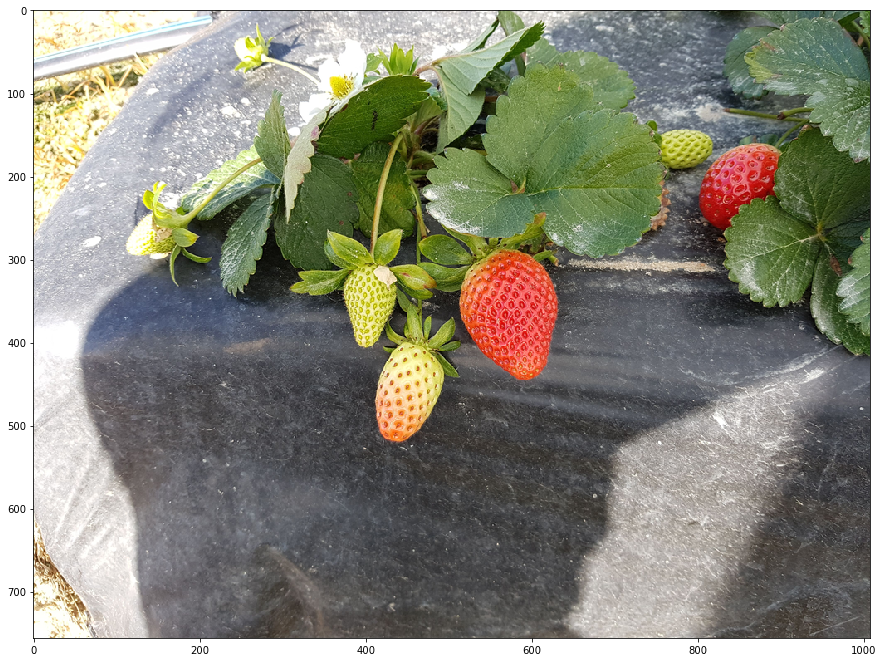

In [6]:
# load the original image
ori = cv2.imread('8_ori.png')

show(ori)

ori.shape

### Bounding Box Data

In [7]:
def get_bboxes(filename):
    # load the bounding box data
    bbox_data = np.loadtxt(filename, delimiter=' ')
    
    if len(bbox_data.shape) == 1:
        bbox_data = [bbox_data]

    # extract the bounding boxes from the data
    bbox = []
    for row in bbox_data:
        ripeness_class_id = int(row[0])
        center_x = row[1] * ori.shape[1]
        center_y = row[2] * ori.shape[0]
        width_x = row[3] * ori.shape[1]
        width_y = row[4] * ori.shape[0]

        # create the bounding box
        xmin = round((center_x - width_x / 2))
        xmax = round((center_x + width_x / 2))
        ymin = round((center_y - width_y / 2))
        ymax = round((center_y + width_y / 2))
        bbox.append([xmin, ymin, xmax, ymax, ripeness_class_id])
    return bbox

In [ ]:
def get_bdata(file_list):
    for filename in file_list:
        # load the bounding box data
        bbox_data = np.loadtxt(filename, delimiter=' ')
        
        if len(bbox_data.shape) == 1:
            bbox_data = [bbox_data]
        
        bbox = []
        for row in bbox_data:
            ripeness_class_id = int(row[0])
            center_x = row[1]
            center_y = row[2]
            width_x = row[3]
            width_y = row[4]
            item_data = np.stack([center_x, center_y, width_x, width_y], axis=1)
            bbox.append(item_data)

In [8]:
 def get_pic_data(box, image, x_, y_):
    for bbox in box:
        # extract the features from the image
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2]
        ymax = bbox[3]
        img = image[ymin:ymax, xmin:xmax]

        img = cv2.resize(img, (32, 32))

        # add the features and labels to the input and output data
        x_.append(img)
        y_.append(bbox[4])

    # convert the input and output data to numpy arrays
    x_ = np.array(x_)
    y_ = np.array(y_)

In [9]:
def get_train_data(imgs, bboxes):
    # create the input and output data for the model
    x_ = []
    y_ = []
    
    for index, img in enumerate(imgs):
        bbox = get_bboxes(bboxes[index])

        get_pic_data(bbox, img, x_, y_)
    
    return x_, y_

In [10]:
def train_model(model, x_train, y_train):
    # create a deep learning model
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # compile and fit the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    start = time.time()
    history = model.fit(x_train, y_train, epochs=10, validation_split=0.1)
    end = time.time()
    print('Running time = {} min {} s'.format(int((end - start) / 60), int((end - start) % 60)))
    
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Get img data

In [89]:
rips=get_all_imgs('../00_data/02_instance+ripeness_segmentation')

In [11]:
inst=get_all_imgs('../00_data/03_instance_segmentation')

In [90]:
imgs=get_all_imgs('../00_data/04_1-250')

In [12]:
bboxes = get_all_txts('../00_data/01_bounding_box')

In [13]:
bboxes[0]

'../00_data/01_bounding_box\\1.txt'

In [67]:
# X, y = get_train_data(imgs, bboxes)

X, y = inst, bboxes

X = np.array(X) / 255
y = np.array(y)

In [70]:
X.shape

(17366, 32, 32, 3)

In [74]:
# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Epoch 1/10
391/391 [==============================] - 18s 38ms/step - loss: 0.0766 - accuracy: 0.9772 - val_loss: 0.0063 - val_accuracy: 0.9971
Epoch 2/10
391/391 [==============================] - 15s 37ms/step - loss: 0.0167 - accuracy: 0.9965 - val_loss: 0.0092 - val_accuracy: 0.9978
Epoch 3/10
391/391 [==============================] - 15s 37ms/step - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 4/10
391/391 [==============================] - 15s 37ms/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/10
391/391 [==============================] - 14s 37ms/step - loss: 0.0118 - accuracy: 0.9972 - val_loss: 0.0039 - val_accuracy: 0.9986
Epoch 6/10
391/391 [==============================] - 15s 37ms/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.0022 - val_accuracy: 0.9993
Epoch 7/10
391/391 [==============================] - 14s 36ms/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0025 - val_accuracy:

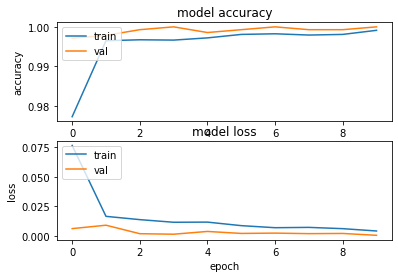

In [75]:
model = Sequential()
train_model(model, X_train, y_train)

In [88]:
preds = model.predict(X_train)
y_pred = np.argmax(preds, axis=1)
# y_train1 = np.argmax(y_train, axis=1)
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
# y_test1 = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

435/435 [==============================] - 7s 15ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10030
           1       1.00      1.00      1.00      2303
           2       1.00      1.00      1.00      1559

    accuracy                           1.00     13892
   macro avg       1.00      1.00      1.00     13892
weighted avg       1.00      1.00      1.00     13892

[[10025     1     4]
 [    5  2297     1]
 [    2     0  1557]]
109/109 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2460
           1       1.00      1.00      1.00       603
           2       1.00      0.99      1.00       411

    accuracy                           1.00      3474
   macro avg       1.00      1.00      1.00      3474
weighted avg       1.00      1.00      1.00      3474

[[2460    0    0]
 [   3  600    0]
 [   3    0  408]]


In [96]:
haar_X, haar_Y = get_train_data(imgs, bboxes)

In [102]:
haar_X = np.array(haar_X)

In [105]:
haar_X.shape

(1373, 32, 32, 3)

In [106]:
#提取haar特征
haar_cascade = cv2.CascadeClassifier("strawberries.xml")
features = haar_cascade.detectMultiScale(haar_X, scaleFactor=1.1,minNeighbors=10)

#训练haar特征
haar_cascade.train(haar_X,features)

#保存haar特征
haar_cascade.save("strawberries.xml")

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [ ]:
# Read bounding box data
bbox_data = read_bbox_data() # Read bounding box data

# Iterate through each bounding box
for bbox in bbox_data:
    # Get the coordinates of the bounding box
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    
    # Draw a rectangle on the image with the coordinates
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)

# Save the image
cv2.imwrite('output.jpg', img)